In [1]:
using CSV, FileIO, DataFrames, Dates
using Plots, StatsPlots

In [2]:
region = "japan"
catalog = "jma"
mkpath("./results/$region/")

"./results/japan"

In [3]:
df = CSV.read("./data/$region.csv", DataFrame);
first(df,5)

Row,Datetime,Latitude,Longitude,Depth,Magnitude,Magnitude_type
,DateTime,Float64,Float64,Float64,Float64,String1
1,1995-01-01T00:01:30.890,38.9317,142.515,29.97,1.7,V
2,1995-01-01T00:05:26.940,33.6188,131.883,93.6,1.8,V
3,1995-01-01T00:14:22.400,36.6195,139.435,11.27,1.8,V
4,1995-01-01T00:15:53.520,40.2385,143.69,0.08,2.6,V
5,1995-01-01T00:18:10.180,40.2408,143.597,0.01,3.1,V


In [5]:
length(df.Magnitude)

3422706

In [4]:
# Using describe function to get statistics of a dataset
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Datetime,,1995-01-01T00:01:30.890,2011-06-07T20:29:12.580,2020-08-31T23:55:49.130,0,DateTime
2,Latitude,35.4245,17.4093,35.6448,50.4268,0,Float64
3,Longitude,136.931,118.905,138.404,156.681,0,Float64
4,Depth,23.2793,0.0,11.73,698.4,0,Float64
5,Magnitude,1.27183,0.1,1.1,9.0,0,Float64
6,Magnitude_type,,D,,v,0,String1


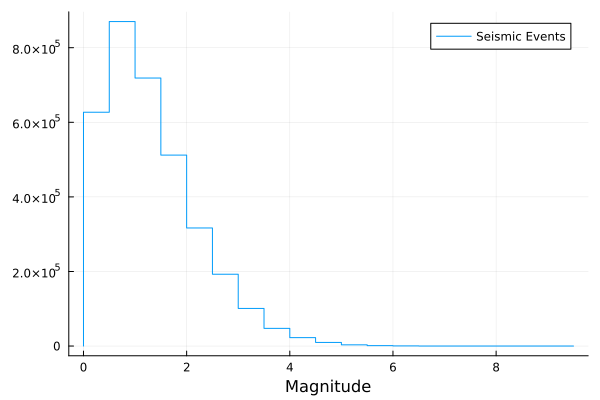

In [12]:
fig = Plots.histogram(df[:,:Magnitude],
                    bins = 40, xlabel = "Magnitude", label="Seismic Events")

savefig("./results/$region/$(region)_histogram_events_magnitudes.png")
fig

In [13]:
function join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold)
	#######################################################
	# Get all counts for all years (no magnitude bounds)
	#######################################################

	# Trims the dataframe by year
	df_trimmed = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .&
					(df.Magnitude .> magnitude_threshold),:]

	# Extracts just the year and puts it in the dataframe
	df_transformed = transform(df_trimmed, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year
	df_counted = combine(groupby(df_transformed, :Year), nrow => Symbol("count"));

	return df_counted
end

function join_on_counted(df,trim_year,minmag,maxmag)
	#######################################################
	# Get all counts for all years and magnitude thresholds
	#######################################################
	
	# Trims the dataframe by year and magnitude threshold
	df_trimmed_mag = df[(df.Datetime .> DateTime(trim_year,1,1,0,0,0)) .& 
						  (df.Magnitude .>= minmag) .&
						  (df.Magnitude .< maxmag),:]
	
	# Extracts just the year and puts it in the dataframe
	df_transformed_mag = transform(df_trimmed_mag, :Datetime => ByRow(year) => :Year)

	# Counts the number of occurences of each year resulting in number of events per year per magnitude
	df_counted_mag = combine(groupby(df_transformed_mag, :Year), nrow => Symbol("count_mag_$minmag"));

	# return outerjoin(df_counted, df_counted_mag, on= :Year)
	return df_counted_mag
end

join_on_counted (generic function with 1 method)

In [14]:
trim_year = year(minimum(df.Datetime))
magnitude_threshold = 0.0;
df_counted = join_on_counted_no_mag_bounds(df,trim_year,magnitude_threshold);

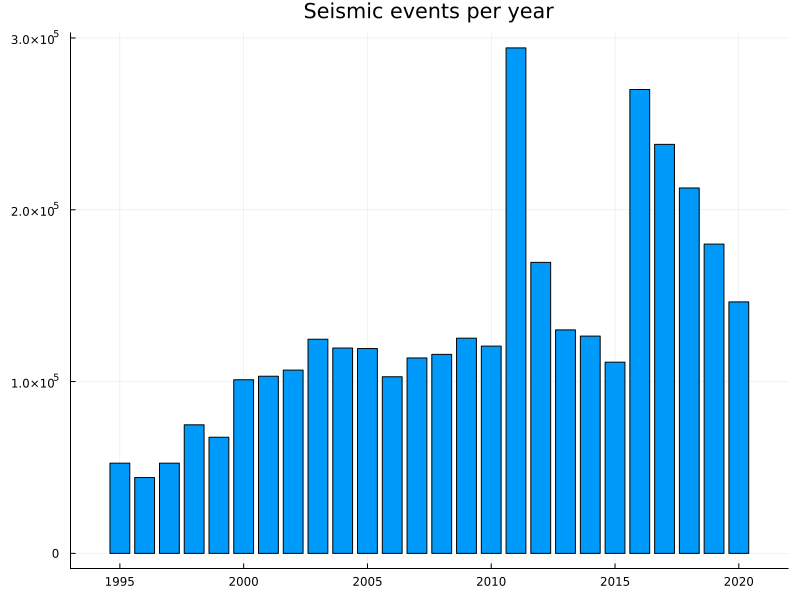

In [15]:
fig = bar(df_counted.Year, df_counted.count, 
	orientation=:vertical, 
	title="Seismic events per year",
    legend=false)
	# label="Seismic Events")
StatsPlots.plot!(size=(800,600))

In [16]:
for minmag=Int(floor(minimum(df.Magnitude))):Int(floor(maximum(df.Magnitude)))
	maxmag=minmag+1
	df_counted_mag_extra = join_on_counted(df,trim_year,minmag,maxmag)

	leftjoin!(df_counted, df_counted_mag_extra, on=:Year,makeunique=true)
	df_counted[!,Symbol("count_mag_$minmag")] = replace(df_counted[!,Symbol("count_mag_$minmag")], missing => 0)
end

In [17]:
df_counted

Row,Year,count,count_mag_0,count_mag_1,count_mag_2,count_mag_3,count_mag_4,count_mag_5,count_mag_6,count_mag_7,count_mag_8,count_mag_9
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1995,52493,3092,21909,18708,6840,1647,254,37,6,0,0
2,1996,44112,4678,20330,13522,4341,1053,161,27,0,0,0
3,1997,52522,7768,26390,13702,3766,776,107,13,0,0,0
4,1998,74830,22333,33164,14279,4149,817,77,9,2,0,0
5,1999,67585,21702,29084,12226,3674,789,96,12,2,0,0
6,2000,101049,30438,35664,25197,7959,1606,157,23,5,0,0
7,2001,103093,47524,36217,14356,3954,885,141,15,1,0,0
8,2002,106668,52343,35376,13706,4139,928,158,13,5,0,0
9,2003,124661,59681,41973,16954,4742,1122,164,21,3,1,0


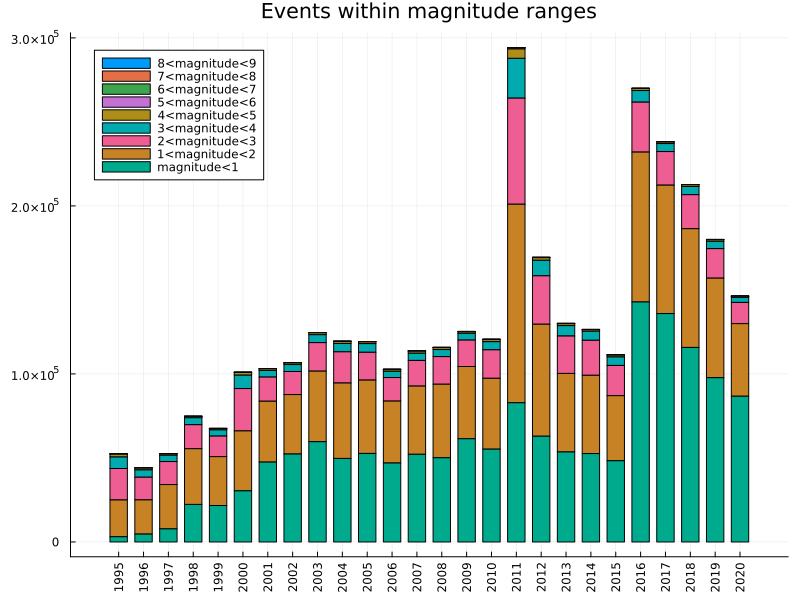

In [18]:
mags=[]
for minmag=Int(floor(minimum(df.Magnitude))):Int(floor(maximum(df.Magnitude)))
	push!(mags,df_counted[!,Symbol("count_mag_$minmag")])
end

ticklabels = string.(collect(minimum(df_counted.Year):maximum(df_counted.Year)))

fig = groupedbar([ mags[9] mags[8] mags[7] mags[6] mags[5] mags[4] mags[3] mags[2] mags[1] ],
			bar_position = :stack,
			bar_width=0.7,
			xticks=(1:length(df_counted.Year), ticklabels),
			xrotation=90,
			title="Events within magnitude ranges",
			label=["8<magnitude<9" "7<magnitude<8" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" "1<magnitude<2" "magnitude<1"])

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/$(region)_events_per_year_mags.png")
fig

In [20]:
# Test to check if all quakes have been properly placed in magnitude bracket 
quakes=0
for minmag=Int(floor(minimum(df.Magnitude))):Int(floor(maximum(df.Magnitude)))
	quakes+= sum(df_counted[!,Symbol("count_mag_$minmag")])
end
quakes == sum(df_counted[!,:count])

true

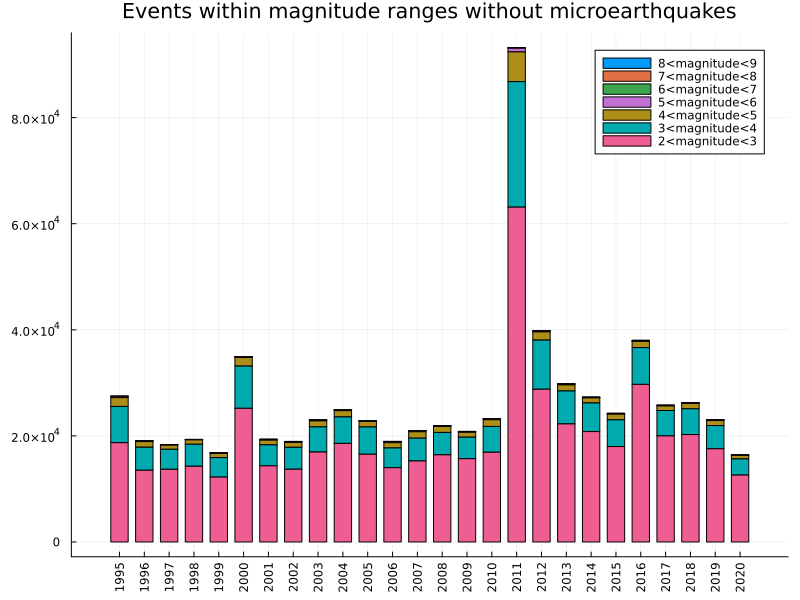

In [21]:
fig = groupedbar([ mags[9] mags[8] mags[7] mags[6] mags[5] mags[4] mags[3]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:length(df_counted.Year), ticklabels),
				xrotation=90,
				title="Events within magnitude ranges without microearthquakes",
				label=["8<magnitude<9" "7<magnitude<8" "6<magnitude<7" "5<magnitude<6" "4<magnitude<5" "3<magnitude<4" "2<magnitude<3" ]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/$(region)_events_per_year_mags_no_microearthquakes.png")
fig

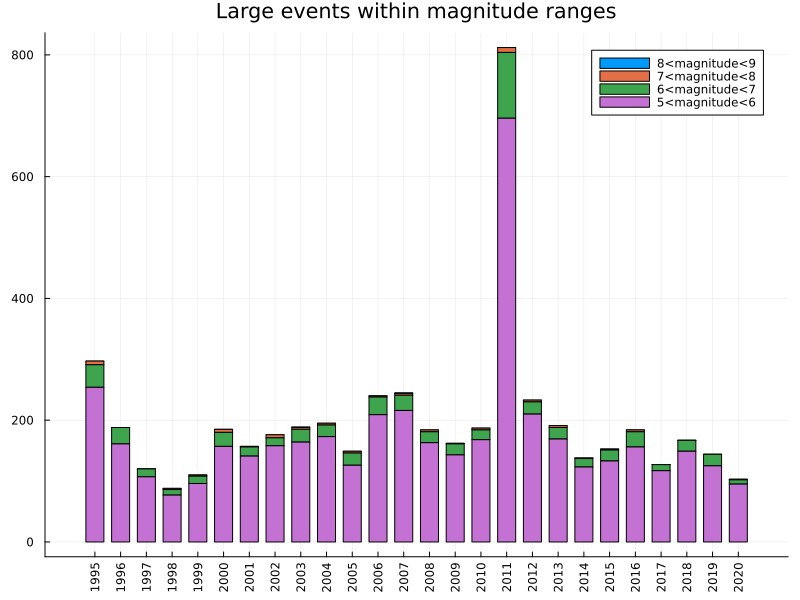

In [22]:
fig = groupedbar([ mags[9] mags[8] mags[7] mags[6]],
				bar_position = :stack,
				bar_width=0.7,
				xticks=(1:length(df_counted.Year), ticklabels),
				xrotation=90,
				title="Large events within magnitude ranges",
				label=["8<magnitude<9" "7<magnitude<8" "6<magnitude<7" "5<magnitude<6"]
				)

StatsPlots.plot!(size=(800,600))

savefig("./results/$region/$(region)_events_per_year_mags_large.png")
fig